In [23]:
import numpy as np
from datetime import date, datetime, timedelta# as in python date is not a type of their own, we need import "python datetime module" to work with date, this module has classes like date, time, datetime, timedelta...
import pandas as pd # python library for data analysis 
import json # library to parse JSON
import matplotlib.pyplot as plt # library for creating visualizations
import plotly.graph_objects as go # library for creating interactive visualizations
import plotly.express as px # library for creating interactive visualizations
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans # sklearn is a machine learning library
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import ipywidgets as widgets

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [3]:
path = './data/'
olist_customer = pd.read_csv(path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv(path + 'olist_orders_dataset.csv')
olist_products = pd.read_csv(path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')
olist_translation = pd.read_csv(path + 'product_category_name_translation.csv')

df = pd.read_csv(path+'merged_data.csv')

In [13]:
df['order_purchase_timestamp'] = pd.to_datetime(df.order_purchase_timestamp)
df['order_approved_at'] = pd.to_datetime(df.order_approved_at)
df['order_delivered_carrier_date'] = pd.to_datetime(df.order_delivered_carrier_date)
df['order_delivered_customer_date'] = pd.to_datetime(df.order_delivered_customer_date)
df['order_estimated_delivery_date'] = pd.to_datetime(df.order_estimated_delivery_date)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Unnamed: 0                     115609 non-null  int64         
 1   customer_id                    115609 non-null  object        
 2   customer_unique_id             115609 non-null  object        
 3   customer_zip_code_prefix       115609 non-null  int64         
 4   customer_city                  115609 non-null  object        
 5   customer_state                 115609 non-null  object        
 6   order_id                       115609 non-null  object        
 7   order_status                   115609 non-null  object        
 8   order_purchase_timestamp       115609 non-null  datetime64[ns]
 9   order_approved_at              115595 non-null  datetime64[ns]
 10  order_delivered_carrier_date   114414 non-null  datetime64[ns]
 11  

### Recency

In [15]:
recency = df.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
recency.rename(columns={'order_purchase_timestamp':'LastPurchaseDate'},inplace = True)
recency.head()

customer_unique_id    LastPurchaseDate
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42

In [16]:
recent_date = df['order_purchase_timestamp'].dt.date.max()
print('The last recent date in the available dataset is: ', recent_date)

The last recent date in the available dataset is:  2018-09-03


In [17]:
recency['Recency'] = recency['LastPurchaseDate'].dt.date.apply(lambda x: (recent_date - x).days)
recency.head()


customer_unique_id    LastPurchaseDate  Recency
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27      116
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27      119
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03      542
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41      326
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42      293

### Frequency

In [19]:
frequency = df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={'order_id':'Frequency'},inplace=True)
frequency.head()


customer_unique_id  Frequency
0  0000366f3b9a7992bf8c76cfdf3221e2          1
1  0000b849f77a49e4a4ce2b2a4ca5be3f          1
2  0000f46a3911fa3c0805444483337064          1
3  0000f6ccb0745a6a4b88665a16c9f078          1
4  0004aac84e0df4da2b147fca70cf8255          1

### Monetary

In [20]:
monetary = df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.rename(columns={'payment_value':'Monetary'},inplace=True)
monetary.head()

customer_unique_id  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f     27.19
2  0000f46a3911fa3c0805444483337064     86.22
3  0000f6ccb0745a6a4b88665a16c9f078     43.62
4  0004aac84e0df4da2b147fca70cf8255    196.89

In [21]:
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id').drop(columns='LastPurchaseDate')
rfm.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19
2  0000f46a3911fa3c0805444483337064      542          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89

In [26]:
dfcs=StandardScaler().fit_transform(rfm.drop(["customer_unique_id"], axis=1))
dfcs

array([[-0.82685819, -0.16042614, -0.11319707],
       [-0.80727141, -0.16042614, -0.29483509],
       [ 1.95446456, -0.16042614, -0.2013638 ],
       ...,
       [ 2.15686129, -0.16042614, -0.15981396],
       [-0.77462678, -0.16042614, -0.12619723],
       [ 1.60843145, -0.16042614, -0.22457723]])

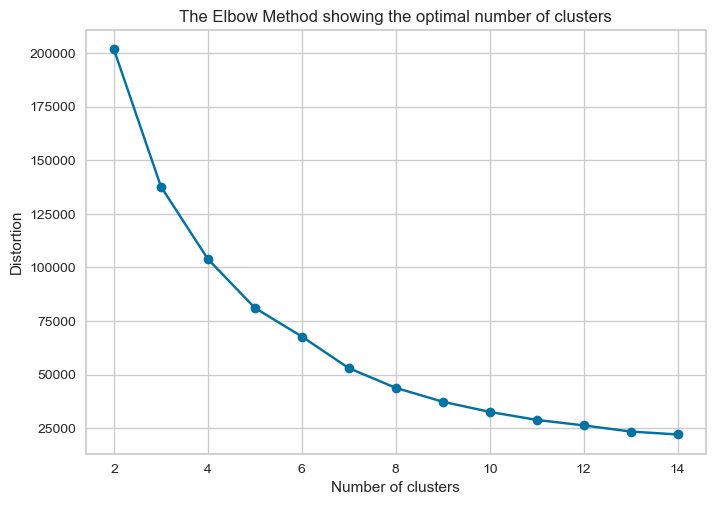

In [28]:
distortions=[]
for i in range(2,15):
    kmodel=KMeans(n_clusters=i,
                 n_init=5, # run 5 times with different random inicial centroids to avoid suboptimal solutions
                 random_state=1)
    kmodel.fit(dfcs)
    distortions.append(kmodel.inertia_) # KMeans inertia = Sum of Squares Errors (SSE)
    
plt.plot(range(2,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

In [34]:
kmodel=KMeans(n_clusters=10, n_init=5, random_state=42)
kmodel.fit(dfcs)
silhouette_score(dfcs, kmodel.labels_)

0.4555655670524479

In [35]:
rfm["cluster_kmeans"] = kmodel.fit_predict(dfcs)

fig= px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary', color='cluster_kmeans',opacity=0.5)
fig.update_traces(marker_size = 3)
fig.show()

In [37]:
kmodel.cluster_centers_

array([[ 4.99167348e-01, -1.60426136e-01, -8.66710690e-02],
       [-9.77574141e-02,  4.64186855e+00,  2.88374421e-01],
       [-3.57552522e-01, -1.60426136e-01, -9.32018744e-02],
       [ 1.61274014e+00, -1.60426136e-01, -7.71583054e-02],
       [-3.16296130e-01,  1.76049174e+00,  3.77852355e+01],
       [ 6.29092451e-01, -1.60426136e-01,  1.72753663e+02],
       [-1.31907094e-02,  4.06511431e-01,  1.06758206e+01],
       [-2.57606373e-01,  1.13045116e+01,  7.90754604e-01],
       [-1.15076381e+00, -1.60426136e-01, -8.11728269e-02],
       [-7.39816394e-02, -1.60426136e-01,  2.41744456e+00]])